In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

cat


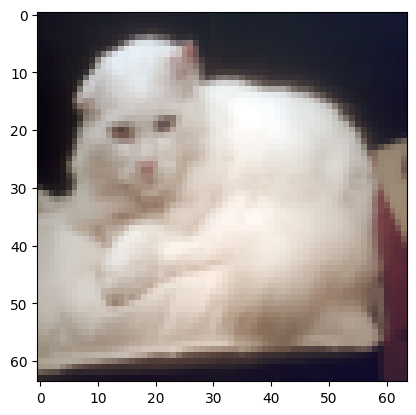

In [15]:
plt.imshow(train_set_x_orig[13])
print(classes[np.squeeze(train_set_y[:,25])].decode('utf-8'))

In [20]:
# the dataset info
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = ", m_train)
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3 channels)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train =  209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3 channels)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [24]:
# image flattenning (making 1D from 3D array for processing of ML model)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# the output must be 12288 = 64 x 64 x 3
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

# image standartization (values must be between 0 and 1)
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255.

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [28]:
# We have binary classification so we can use sigmoid activation function here:
def sigmoid(z): # z is a weighted input z = weight_matrix^T * x + bias
    s = 1 / (1 + np.exp(-z))
    
    return s

print(sigmoid(0))
print(sigmoid(9.2))

0.5
0.9998989708060922


In [30]:
# The bias is a constant that we add, like an intercept to a linear equation.
# This gives the neural network an extra parameter to tune in order to improve the fit.
# The bias can be initialized to 0.
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))    # weight matrix that will be initialize with zeros
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

dim = 2
w, b = initialize_with_zeros(dim)

print(w)
print(b)

[[0.]
 [0.]]
0


In [ ]:
# next step is to define function for forward and backpropagation
# FP generate a prediction and calculate the cost (cost function we need to minimize)

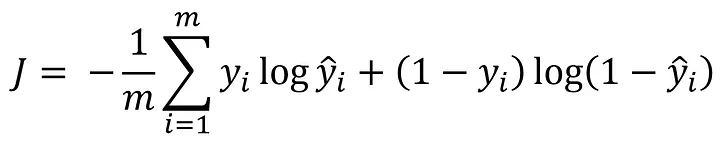


Where y is an observation and y_hat is a prediction

Then, backpropagation calculates the gradient, or the derivatives. This will be useful during the optimization phase, because when the derivatives are close or equal to 0, it means that our parameters are optimized to minimize the cost function.

In [31]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    #Forward propagation
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1/m) * np.sum(Y * np.log(A) + (1-Y) * (np.log(1-A)))
    
    #Backward propagation
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw': dw, 'db': db}
    
    return grads, cost

In [32]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


we need to repeat forward propagation and backpropagation to update the parameters in order to minimize the cost function. This is done using gradient descent. For that, we set a learning rate which is a small positive value that controls the magnitude of change of the parameters at each run.

It is important to choose an appropriate value for the learning rate a shown below: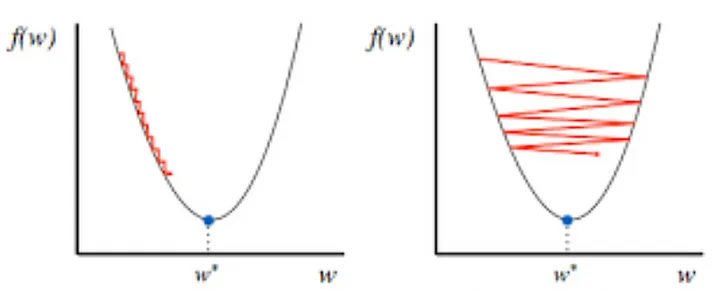

If it is too small, it will take a longer time to train your neural network as seen on the left. If it is too big, you might never reach the global minimum and gradient descent will oscillate forever.

In our case, we will update the parameters like this: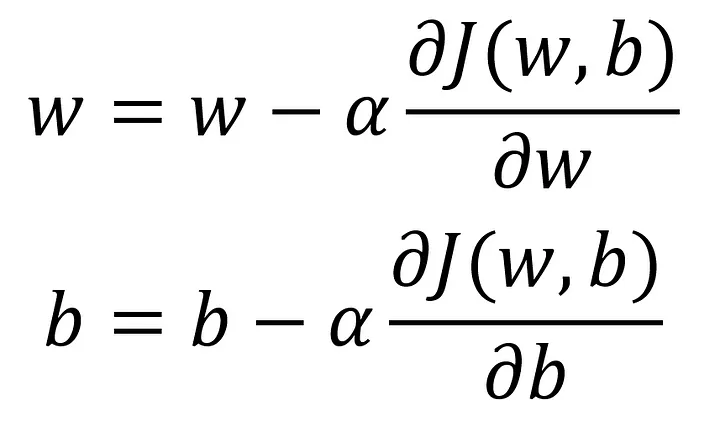

Where alpha is the learning rate.

In [33]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    
    costs=[]
    
    for i in range(num_iterations):
        
        #Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        #Get derivatives
        dw = grads['dw']
        db = grads['db']
        
        #Update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        #Record costs
        if i % 100 == 0:
            costs.append(cost)
            
        #Print cost every 100 training examples
        if print_cost and i % 100 == 0:
            print('Cost after iteration %i: %f' % (i, cost))
            
    params = {'w': w, 'b': b}
    grads = {'dw': dw, 'db': db}
    
    return params, grads, costs

In [34]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


Now we need to do is compute a prediction. Knowing that the sigmoid function outputs a value between 0 and 1, we will determine that if the value is greater than 0.5, we predict a positive example (it is a cat). Otherwise, we will predict a false example (not a cat).

In [35]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    #Compute probability vector
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [36]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


now combining all the functions into a model:

In [48]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    #Initialize parameters with 0s
    w, b = initialize_with_zeros(X_train.shape[0])
    
    #Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    #Retrive parameters w, b from dictionary
    w = parameters['w']
    b = parameters['b']
    
    #Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    #Print test/train errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    modelMetrix = {'costs': costs,
         'Y_prediction_test': Y_prediction_test,
         'Y_prediction_train': Y_prediction_train,
         'w': w,
         'b': b,
         'learning_rate': learning_rate,
         'num_iterations': num_iterations}
    
    return modelMetrix

In [49]:
# testing the model
modelMetrix = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147


Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


In [50]:
#missclassified image
#plt.imshow(test_set_x[:,5].reshape((num_px, num_px, 3)))
#d['Y_prediction_test'][0][5]

Plotting the cost as a function of iterations (learning curve):

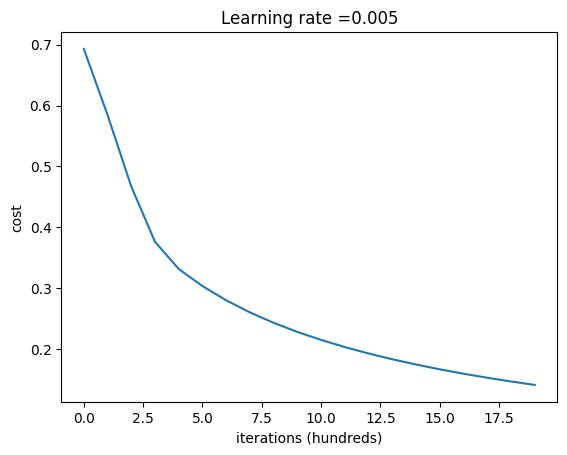

In [51]:
costs = np.squeeze(modelMetrix['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
plt.title("Learning rate =" + str(modelMetrix["learning_rate"]))
plt.show()

To improve the model performance, we can experiment with different learning rates and number of iterations

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



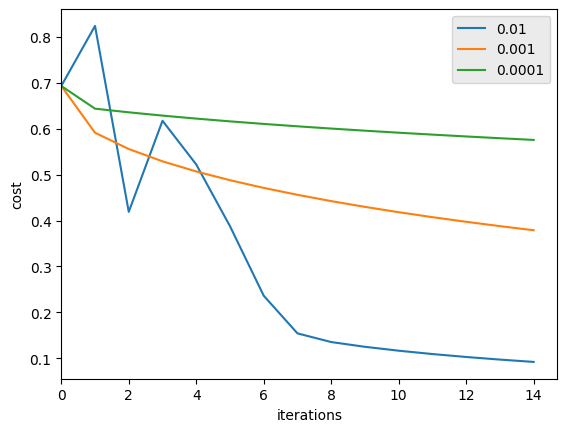

In [41]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')
plt.xlim(left=0)

legend = plt.legend(loc='upper right', shadow=False)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Cost after iteration 2000: 0.135608
Cost after iteration 2100: 0.130708
Cost after iteration 2200: 0.126137
Cost after iteration 2300: 0.121861
Cost after iteration 2400: 0.117855
Cost after iteration 2500: 0.114093
Cost after iteration 2600: 0.110554
Cost after iteration 2700: 0.107219
Cost

0.0

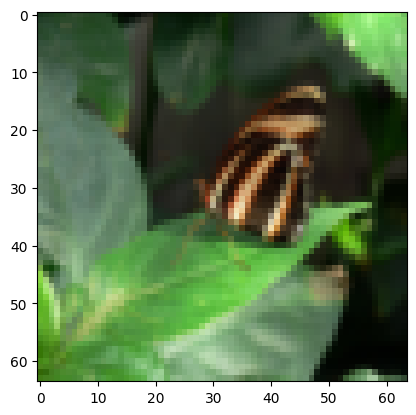

In [42]:
modelMetrix = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 10000, learning_rate = 0.005, print_cost = True)

#Check if previously wrong prediction is now right
plt.imshow(test_set_x[:,5].reshape((num_px, num_px, 3)))
modelMetrix['Y_prediction_test'][0][5]